In [24]:
from utils import click
import pyautogui as pg
import pygetwindow 

window_title = pygetwindow.getActiveWindow().title

window = pg.getWindowsWithTitle(window_title)[0]
window.bottom

1448

In [12]:
windows = pygetwindow.getAllWindows()
window_titles = [w.title for w in windows]
window_titles

['',
 '',
 '',
 '',
 '',
 'test.ipynb - arknights_dalies_automation - Visual Studio Code',
 'Pyautogui automation setup',
 '\u200eРита – (23171)',
 'Arknights - blaze000ri',
 '[Admin] [Tun] NekoBox (4.0.1-2024-12-12) [VLESS] США🇺🇸@Default',
 'MPos - Mouse Position download | SourceForge.net — Mozilla Firefox',
 'MPos-v.0.5.0-Portable - File Explorer',
 'MPos | X: 568 Y: 442',
 '',
 '@ケイデン - Discord',
 'HWMonitor',
 'Settings',
 'Settings',
 '',
 '',
 '',
 '',
 'Windows Input Experience',
 '',
 'NVIDIA GeForce Overlay',
 '',
 '',
 '',
 '',
 '',
 '',
 'Karing',
 'Snipping Tool',
 'Program Manager']

In [2]:
import re

from PIL.ImageChops import screen
from time import sleep
import pyautogui as pg
import pygetwindow as gw
import mss
import numpy as np
import math

def get_arknights_window_title(keywords_to_exclude=[]):
    """Get the title of the Arknights window."""
    windows = gw.getAllWindows()
    keywords_to_exclude.append('arknights_dalies_automation')
    windows = [w for w in windows if "arknights" in w.title.lower().strip() \
               and not any(name for name in keywords_to_exclude if name in w.title.lower().strip())]

    if windows:
        return windows[0].title
    return None

def get_window_info(window_title):
    """Get the position and size of a window by its title."""
    windows = gw.getWindowsWithTitle(window_title)
    if not windows:
        return None
    window = windows[0]
    return {
        'left': window.left,
        'right': window.right,
        'top': window.top,
        'bottom': window.bottom,
        'width': window.width,
        'height': window.height,
        'title': window.title
    }

arknights_title = get_arknights_window_title()
print(arknights_title)
print(get_window_info(arknights_title))

windowed_offsets = {
    'google_play': (9, 8, 31, 8)
}

class ArknightsWindow:
    """Class to manage the Arknights window."""
    
    def __init__(self, title=None, windowed_mode_interface='google_play'):
        if title is None:
            title = get_arknights_window_title()
        self.title = title
        self.window = get_window_info(title)
        self.width = self.window['width']
        self.height = self.window['height']
        self.last_screenshot = None
        self.is_windowed = False

        self.windowed_mode_interface = windowed_mode_interface
        self.windowed_offset_left = windowed_offsets.get(windowed_mode_interface, 0)[0]
        self.windowed_offset_right = windowed_offsets.get(windowed_mode_interface, 0)[1]
        self.windowed_offset_top = windowed_offsets.get(windowed_mode_interface, 0)[2]
        self.windowed_offset_bottom = windowed_offsets.get(windowed_mode_interface, 0)[3]
        
        with mss.mss() as sct:
            monitor = sct.monitors[0]
            self.offset_x = monitor['left']
            self.offset_y = monitor['top']

    def refresh_window_info(self):
        """Refresh window information in case window moved/resized."""
        self.window = get_window_info(self.title)
        if self.window:
            self.width = self.window['width']
            self.height = self.window['height']

    def get_scaled_coords(self, base_x, base_y,
                          base_w=1920, base_h=1080):
        """Return _window-relative_ coords, scaled to current size."""
        if self.is_windowed:
            # Adjust for windowed mode offsets
            base_x += self.windowed_offset_left
            base_y += self.windowed_offset_top
            base_w -= (self.windowed_offset_left + self.windowed_offset_right)
            base_h -= (self.windowed_offset_top + self.windowed_offset_bottom)

        scale_x = int(base_x * self.width / base_w)
        scale_y = int(base_y * self.height / base_h)
        return scale_x, scale_y
    
    def get_screen_coords(self, base_x, base_y,
                          base_w=1920, base_h=1080):
        """Return _screen-relative_ coords, scaled to current size."""
        coords = self.get_scaled_coords(base_x, base_y, base_w, base_h)
        scale_x = coords[0] + self.window['left'] 
        scale_y = coords[1] + self.window['top']
        return scale_x, scale_y
    
    def make_screenshot(self):
        """Grab the full virtual screen, then crop to the window."""
        self.refresh_window_info()
        with mss.mss() as sct:
            mon = sct.monitors[0]   # full virtual screen
            full = np.array(sct.grab(mon))[:, :, :3][:, :, ::-1]
        
        # compute window’s top-left _inside_ that full image
        left_in_full = self.window['left'] - mon['left']
        top_in_full  = self.window['top']  - mon['top']
        
        # slice out just the Arknights window
        w, h = self.width, self.height
        cropped = full[top_in_full: top_in_full + h,
                       left_in_full: left_in_full + w]

        self.last_screenshot = cropped
        return cropped

    def get_pixel_color(self, x, y):
        """x, y must now be window-relative coords—just index into cropped."""
        screenshot = self.make_screenshot()
        return tuple(screenshot[y, x].tolist())

    def check_color_at(self, base_x, base_y, expected_rgb, confidence=1):
        # Refresh window info before checking
        self.refresh_window_info()
        expected_rgb = tuple(expected_rgb)
        found_rgb = self.get_pixel_color(*self.get_scaled_coords(base_x, base_y))
        if confidence < 1:
            # Calculate color distance (0-255 per channel)
            distance = math.sqrt(sum((a - b) ** 2 for a, b in zip(found_rgb, expected_rgb)))
            max_distance = math.sqrt(3 * 255 ** 2)  # Maximum possible distance
            
            # Convert confidence to threshold (higher confidence = lower threshold)
            threshold = (1 - confidence) * max_distance
            return distance <= threshold
            
        return found_rgb == expected_rgb


ark_window = ArknightsWindow()
coords = ark_window.get_scaled_coords(486, 435)
screen_coords = ark_window.get_screen_coords(486, 435)
print(coords, screen_coords)  # Example usage

print(ark_window.check_color_at(*coords, (255, 255, 255)))

print(ark_window.get_pixel_color(*coords))  # Example usage

Arknights - blaze000ri
{'left': 2560, 'right': 4480, 'top': -312, 'bottom': 768, 'width': 1920, 'height': 1080, 'title': 'Arknights - blaze000ri'}
(486, 435) (3046, 123)
False
(222, 223, 222)
(222, 223, 222)


In [ ]:
pg.click(*screen_coords, clicks=1, interval=0.1)

In [3]:
ark_window = ArknightsWindow()
class DailyRecruits:
    """
    This class automates the daily recruitment process in Arknights.
    """
    
    def __init__(self, ark_window):
        self.ark_window = ark_window
        self.coords = {
            1: (486, 435),
            2: (1433, 435),
            3: (486, 851),
            4: (1433, 851),
        }
    
    def _click_recruitment_tile(self, n: int):
        """Clicks the nth recruitment tile (1–4)."""
        screen_coords = self.ark_window.get_screen_coords(*self.coords[n])
        pg.click(*screen_coords)

    def _confirm_recruitment(self, i):
        pg.click(*self.ark_window.get_screen_coords(674, 449))  # set time to 9
        pg.click(*self.ark_window.get_screen_coords(1463, 876))  # confirm recruitment
        
        for _ in range(10000):  # waiting for the loading screen to finish
            check_coords = self.ark_window.get_scaled_coords(self.coords[i][0]-105, self.coords[i][1]+25)    
            if self.ark_window.check_color_at(*check_coords, (255, 255, 255), confidence=0.8):
                print(i, self.coords[i], check_coords)
                print("Recruitment confirmed.")
                break
            sleep(0.001)

    def do_recruitment(self):
        """Perform a full recruitment cycle."""
        print("Starting daily recruitment scenario...")
        for i in range(1, 5):
            self._click_recruitment_tile(i)
            self._confirm_recruitment(i)

    def _click_hiring_tile(self, i):
        """Click the hiring tile to start the recruitment process."""
        screen_coords = self.ark_window.get_screen_coords(self.coords[i][0], self.coords[i][1]-136)
        pg.click(*screen_coords)
        
    def _skip_button(self):
        """Click the skip button to skip the hiring animation."""
        screen_coords = self.ark_window.get_screen_coords(1833, 51)
        pg.click(*screen_coords)

    def do_hiring(self):
        """Perform the hiring process."""
        for i in range(1, 5):
            self._click_hiring_tile(i)
            self._confirm_recruitment(i)

# Usage
daily_recruits = DailyRecruits(ark_window)
daily_recruits.do_recruitment()

Starting daily recruitment scenario...
1 (486, 435) (381, 460)
Recruitment confirmed.
1 (486, 435) (381, 460)
Recruitment confirmed.
2 (1433, 435) (1328, 460)
Recruitment confirmed.
2 (1433, 435) (1328, 460)
Recruitment confirmed.
3 (486, 851) (381, 876)
Recruitment confirmed.
3 (486, 851) (381, 876)
Recruitment confirmed.
4 (1433, 851) (1328, 876)
Recruitment confirmed.
4 (1433, 851) (1328, 876)
Recruitment confirmed.


In [11]:
(486-381, 435-571)

(105, -136)

Screenshot size: (1080, 1920, 3)
Coordinates: (486, 435)


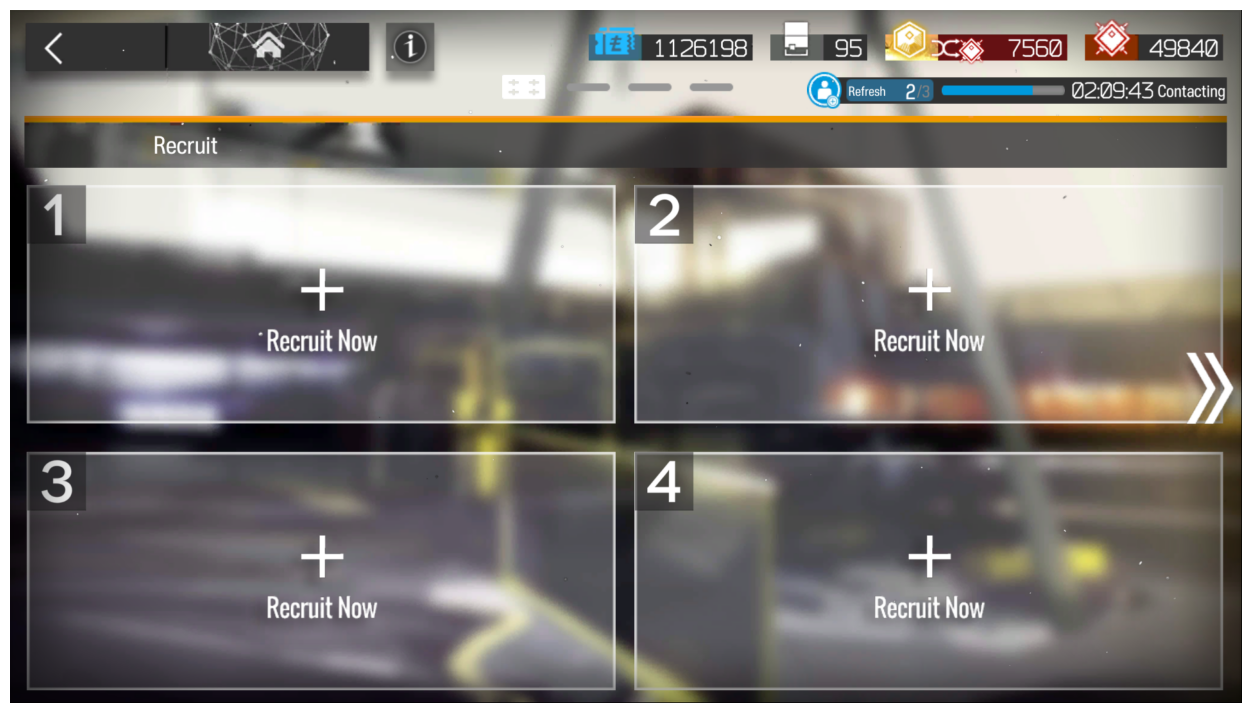

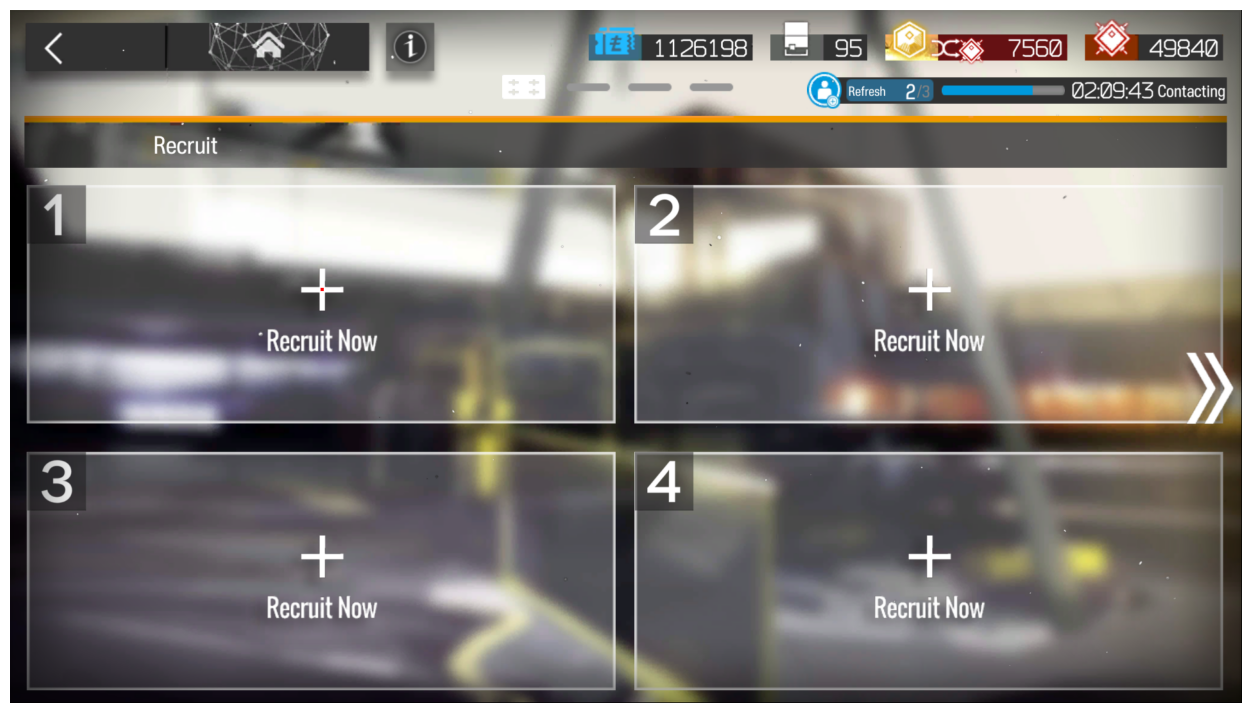

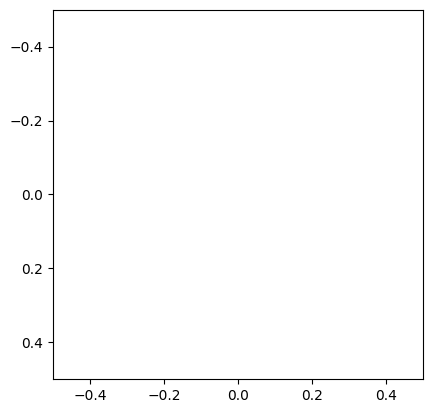

In [222]:
from matplotlib import pyplot as plt
coords = ark_window.get_scaled_coords(486,435)
screenshot = ark_window.make_screenshot()
print(f"Screenshot size: {screenshot.shape}")
print(f"Coordinates: {coords}")
plt.figure(figsize=(16, 9))  # Adjust figure size to match aspect ratio
plt.imshow(screenshot)
plt.axis('off')  # Hide axes
plt.show()

# Create a 5x5 red square around the target pixel
for offset_x in range(-2, 3):
    for offset_y in range(-2, 3):
        x = coords[0] + offset_x
        y = coords[1] + offset_y
        if 0 <= y < screenshot.shape[0] and 0 <= x < screenshot.shape[1]:
            screenshot[y, x] = [255, 0, 0]

plt.figure(figsize=(16, 9))
plt.imshow(screenshot)
plt.axis('off')
plt.show()

plt.imshow(np.array(ark_window.get_pixel_color(*coords)).reshape(1, 1, 3))

In [92]:
screenshot[*[23, 23]]

array([0, 0, 0], dtype=uint8)

In [ ]:
from cv2 import exp
from utils import ArknightsWindow
from time import sleep
from logger import logger
import pyautogui as pg

ark_window = ArknightsWindow()
class DailyRecruits:
    """
    This class automates the daily recruitment process in Arknights.
    """
    
    def __init__(self, use_expedite=False, finish_on_recruitment=True):
        self.coords = {
            1: (486, 435),
            2: (1433, 435),
            3: (486, 851),
            4: (1433, 851),
        }
        self.use_expedite = use_expedite
        self.finish_on_recruitment = finish_on_recruitment
        logger.debug(f"DailyRecruits initialized: expedite={self.use_expedite}, finish_on_recruitment={self.finish_on_recruitment}")

    def _click_recruitment_tile(self, n: int):
        """Clicks the nth recruitment tile (1–4)."""
        absolute_coords = ark_window.get_absolute_coords(*self.coords[n])
        logger.debug(f"Clicking recruitment tile {n} at {absolute_coords}")
        pg.click(*absolute_coords)

    def _click_hiring_tile(self, i):
        """Click the hiring tile to start the recruitment process."""
        absolute_coords = ark_window.get_absolute_coords(self.coords[i][0], self.coords[i][1]+136)
        logger.debug(f"Clicking hiring tile {i} at {absolute_coords}")
        pg.click(*absolute_coords)
        
    def _skip_button(self):
        """Click the skip button to skip the hiring animation."""
        absolute_coords = ark_window.get_absolute_coords(1833, 51)
        logger.debug(f"Clicking skip button at {absolute_coords}")
        pg.click(*absolute_coords)

    def check_tile(self, i):
        """Check the status of the hiring tile."""        
        logger.debug(f"Checking tile status for tile {i}")
        is_plus = ark_window.check_color_at(*self.coords[i], (255, 255, 255), confidence=1)

        # There are only 3 states in which recruitment can be:
        # 1. No recruitment in progress (plus sign)
        # 2. Recruitment in progress (recruitment permit is on the screen)
        # 3. Recruitment done (Any other color in place of recruitment permit)
        if is_plus:
            logger.debug(f"Tile {i} status: no_recruitment")
            return 'no_recruitment'
        else:
            recruitment_permit_coords = ark_window.get_scaled_coords(self.coords[i][0]-105, self.coords[i][1]+25)
            recruitment_in_progress = ark_window.check_color_at(*recruitment_permit_coords, (255, 255, 255), confidence=1)

            if recruitment_in_progress:
                logger.debug(f"Tile {i} status: recruitment_in_progress")
                return 'recruitment_in_progress'
            else:
                logger.debug(f"Tile {i} status: recruitment_done")
                return 'recruitment_done'
    
    def _confirm_recruitment(self, i):
        logger.debug(f"Confirming recruitment for tile {i}")
        pg.click(*ark_window.get_absolute_coords(674, 449))  # set time to 9h
        pg.click(*ark_window.get_absolute_coords(1463, 876))  # confirm recruitment
        
        for _ in range(500):  # waiting for the loading screen to finish
            if self.check_tile(i) == 'recruitment_in_progress':
                break
            else:
                pg.click(*ark_window.get_absolute_coords(1463, 876))
            sleep(0.001)

    def _do_expedite(self, i):
        """Use expedite to speed up the recruitment process."""
        expedite_coords = ark_window.get_absolute_coords(self.coords[i][0]+220, self.coords[i][1]+145)
        confirm_coords = ark_window.get_absolute_coords(1440, 760)
        logger.debug(f"Expediting recruitment for tile {i} at {expedite_coords}")
        pg.click(*expedite_coords)
        sleep(0.01)  # wait for the expedite dialog to appear      
        logger.debug(f"Confirming expedite at {confirm_coords}")
        pg.click(*confirm_coords)

    def do_recruitment(self):
        """Perform a full recruitment cycle."""
        logger.info("Starting daily recruitment scenario...")
        for i in range(1, 5):
            logger.debug(f"Recruitment cycle for tile {i}")
            self._click_recruitment_tile(i)
            self._confirm_recruitment(i)

    def do_hiring(self):
        """Perform the hiring process."""
        logger.info("Starting hiring process...")
        for i in range(1, 5):
            logger.debug(f"Hiring process for tile {i}")
            self._click_hiring_tile(i)
            self._confirm_recruitment(i)

    def do_daily_recruits(self):
        """Main method to execute the daily recruitment scenario based on chosen mode."""
        for i in range(1, 2):
            sleep(1)
            tile_status = self.check_tile(i)
            logger.debug(f"Tile {i} status: {tile_status} in main loop")
            if tile_status == 'no_recruitment':
                self._click_recruitment_tile(i)
                self._confirm_recruitment(i)
            elif tile_status == 'recruitment_in_progress':
                if not self.use_expedite:
                    logger.info(f"Recruitment in progress for tile {i}. Skipping expedite.")
                    continue
                self._do_expedite(i)
                self._click_hiring_tile(i)
                self._skip_button()

                if self.finish_on_recruitment:
                    logger.debug(f"Finish on recruitment: final cycle for tile {i}")
                    self._click_hiring_tile(i)
                    self._confirm_recruitment(i)
            elif tile_status == 'recruitment_done':
                self._click_hiring_tile(i)
                self._confirm_recruitment(i)

# if __name__ == "__main__":
    # daily_recruits = DailyRecruits(use_expedite=True)
    # daily_recruits.do_hiring()
    # daily_recruits.do_daily_recruits()
    # logger.info("Daily recruitment scenario completed.")
    # # status = daily_recruits.check_tile(1)
    # # print(f"Tile 1 status: {status}")
    # # if status == 'recruitment_in_progress':
    # #     daily_recruits._do_expedite(1)
    #     sleep(2)
    #     daily_recruits._click_hiring_tile(1)
    #     daily_recruits._skip_button()

IndexError: index 874 is out of bounds for axis 1 with size 0

In [ ]:
# 

In [37]:
base_x, base_y = 960, 540  # Base coordinates for scaling
base_w, base_h = 1920, 1080  # Base window size for scaling
cur_w, cur_h = 1280, 720  # Current window size
scaled_x = int(base_x * cur_w / base_w)
scaled_y = int(base_y * cur_h / base_h)
print(scaled_x, scaled_y)

640 360


In [72]:
import pyautogui as pg

# Captures all screens as single wide image
screenshot = pg.screenshot()
print(f"Total screenshot size: {screenshot.size}")

Total screenshot size: (2560, 1440)


In [52]:
import mss
import numpy as np

def get_pixel_color(x, y):
    with mss.mss() as sct:
        monitor = sct.monitors[0]  # 0 means the full virtual screen
        screenshot = np.array(sct.grab(monitor))
        return screenshot[y, x][:3].tolist()  # RGB (ignore alpha)

get_pixel_color(960, 540)  # Example usage

[54, 42, 40]

---

In [1]:
from scenarios import DailyRecruits

daily_recruits = DailyRecruits(use_expedite=True, finish_on_recruitment=True)

# daily_recruits._click_recruitment_tile(1)
# daily_recruits._confirm_recruitment(1)
# daily_recruits._do_expedite(4)
# daily_recruits._click_hiring_tile(1)
# daily_recruits._skip_button()
daily_recruits.do_daily_recruits()

2025-08-06 12:00:16,031 - arknights - WARNING - Timeout spam clicking for color to appear
2025-08-06 12:00:22,373 - arknights - WARNING - Timeout spam clicking for color to appear
2025-08-06 12:00:28,614 - arknights - WARNING - Timeout spam clicking for color to appear
2025-08-06 12:00:34,862 - arknights - WARNING - Timeout spam clicking for color to appear
